# Practical 2

**Group composition**: 
- Lucie-Marie BOSCHIAN CAMPANER &bull; [lucie-marie.boschiancampaner@ensiie.fr](mailto:lucie-marie.boschiancampaner@ensiie.fr)
- Khalil BATTIKH &bull; [khalil.battikh@ensiie.fr](mailto:khalil.battikh@ensiie.fr)
- Lucas RODRIGUEZ &bull; [lucas.rodriguez@ensiie.fr](mailto:lucas.rodriguez@ensiie.fr)

**Group ID**: 12

**Author**: *Lucas RODRIGUEZ*

## First steps

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import missingno as msno
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from keras_visualizer import visualizer
from tensorflow.keras.utils import plot_model
from IPython.display import Image
#from keras_tqdm import TQDMNotebookCallback
#from livelossplot import PlotLossesKeras
import tensorflow_addons as tfa

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

# Setting up a fixed random seed for experiment purposes
np.random.seed(1)

The chosen dataset is the following : **Air Quality**.

- Link of the dataset description: https://archive.ics.uci.edu/ml/datasets/Air+Quality
- Direct link to the dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00360/


**Selected strategy** : The given dataset offers a lot of features and observations. However, a lot of irregularities have been detected by us. We have to perform heavy transformations on the dataset using pre-processing operations.

To do so, we can first think about using Numpy, for matrix-based manipulations. However, we have decided to use Pandas to deal with tabular data more easily then convert the output version into a Numpy matrix as input for our NN model.

In [2]:
# Importing the given dataset
file_name = "data/AirQualityUCI.csv"
df = pd.read_csv(filepath_or_buffer=file_name,
                sep=";",
                #index_col="Date",
                na_values=np.nan,
                decimal=",") # Floating point separator for implicit casting

# Making a deep copy for safety reason
df_initial = df.copy(deep=True)

In [3]:
# Some informations about the different columns composing the csv file
df.info()

# General shape of the DataFrame
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


(9471, 17)

In [4]:
# Statistical description of the final dataset
df.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
CO(GT),9357.0,-34.208,77.657,-200.0,0.600,1.500,2.600,11.900
PT08.S1(CO),9357.0,1048.990,329.833,-200.0,921.000,1053.000,1221.000,2040.000
NMHC(GT),9357.0,-159.090,139.789,-200.0,-200.000,-200.000,-200.000,1189.000
C6H6(GT),9357.0,1.866,41.380,-200.0,4.000,7.900,13.600,63.700
PT08.S2(NMHC),9357.0,894.595,342.333,-200.0,711.000,895.000,1105.000,2214.000
NOx(GT),9357.0,168.617,257.434,-200.0,50.000,141.000,284.000,1479.000
PT08.S3(NOx),9357.0,794.990,321.994,-200.0,637.000,794.000,960.000,2683.000
NO2(GT),9357.0,58.149,126.940,-200.0,53.000,96.000,133.000,340.000
PT08.S4(NO2),9357.0,1391.480,467.210,-200.0,1185.000,1446.000,1662.000,2775.000
PT08.S5(O3),9357.0,975.072,456.938,-200.0,700.000,942.000,1255.000,2523.000


The dataset initially contains 9471 rows and 16 columns.

### Dataset description

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value. 


---

0. Date (format: DD/MM/YYYY)
1. Time (format: HH.MM.SS)
2. True hourly averaged concentration CO in $\text{mg}/\text{m}^3$ (reference analyzer) 
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted) 
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted) 
7. True hourly averaged NOx concentration in ppb (reference analyzer) 
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer) 
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted) 
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
12. Temperature (in °C)
13. Relative Humidity (%) 
14. AH: Absolute Humidity


---

Add the choice of target/features


### Dataset references & License



Saverio De Vito (saverio.devito@enea.it), ENEA - National Agency for New Technologies, Energy and Sustainable Economic Development

In [5]:
# A quick overview of the dataset structure
df.head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
5,10/03/2004,23.00.00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,NaN,NaN
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,NaN,NaN
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,NaN,NaN
8,11/03/2004,02.00.00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,NaN,NaN
9,11/03/2004,03.00.00,0.6,1010.0,19.0,1.7,561.0,-200.0,1705.0,-200.0,1235.0,501.0,10.3,60.2,0.7517,NaN,NaN


## Data pre-processing & Data-cleaning

### Drop duplicates

We can handle duplicate rows by using the following instruction


In [6]:
df.drop_duplicates(inplace=True) # we keep the "keep" argument to its default value : "first"
df.shape

(9358, 17)

We have successfully eliminated $9471 - 9347 = \fbox{124}$ rows (especially, most of them were rows filled of NaN values (see next section). 

**Remark** : Most of them have been removed thanks to the `drop_duplicate` operation. However, we still have a remaining row at the end. We remove it.

In [7]:
df.dropna(how="all", inplace=True)
df.shape

(9357, 17)

In [8]:
# We first determine for each column, the number of different values in this column by using the following Pandas method
df.nunique()

Date              391
Time               24
CO(GT)             97
PT08.S1(CO)      1042
NMHC(GT)          430
C6H6(GT)          408
PT08.S2(NMHC)    1246
NOx(GT)           926
PT08.S3(NOx)     1222
NO2(GT)           284
PT08.S4(NO2)     1604
PT08.S5(O3)      1744
T                 437
RH                754
AH               6684
Unnamed: 15         0
Unnamed: 16         0
dtype: int64

### Drop useless columns

We can easily see, thanks to the previous cell, that the last two columns are completely empty

$\Longrightarrow$ We immediately remove them.

In [9]:
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


### Customizing the inner structure of the dataset

We observe that `Date` and `Time` are `object`-typed. Since we want to perform a regression model on our data, we want to explain the target variable with the widest subset of possible features.



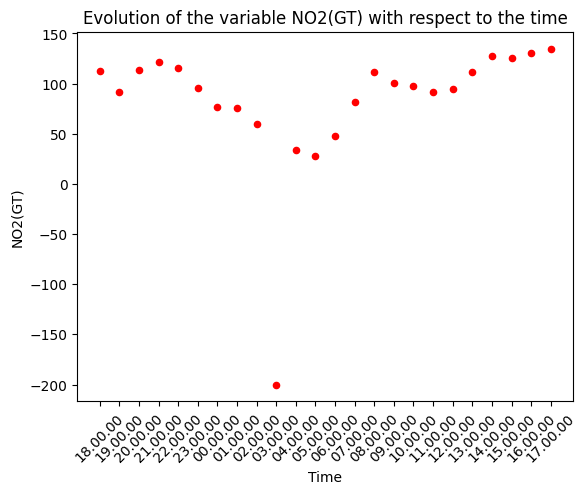

In [10]:
_ = df[0:24].plot.scatter("Time", "NO2(GT)", 
                      rot=45, 
                      color="red"
                     )
_ = plt.title("Evolution of the variable NO2(GT) with respect to the time")

We can see that, on the scale of only one day, the evolution of concentration of some substances is clearly highlighted here.

We have:
- `Date`: DD/MM/YYYY
- `Time`: HH.MM.SS (but the frequency of observation is an hourly-basis.



We also observe that the date range goes from 10/03/2004 to 03/04/2005; we can remove the year detail and only encode the month as follows:
- March 2004 $\longrightarrow 0$
- April 2004 $\longrightarrow 1$ 
- ...

As shown in the below figures, we see that there is no clear reason in keeping the days into the dataset; we remove them.

<img src="img/cal1.png" width=600>

<img src="img/cal2.png" width=600>


In fact, there is no need to keep the days because of the combination of the record id (represented by the index of the row) and the hours.


To conclude, we have decided to keep the months (as an encoded field) and the hours (the minutes and seconds dedicated fields are empty because of the hourly refresh time frequency.

In [11]:
# Creating the month column
get_month = lambda x:x.split("/")[1][1] if x.split("/")[1][0] == '0' else x.split("/")[1]
df["Month"] = df["Date"].apply(get_month)
df["Month"] = pd.to_numeric(df["Month"])

In [12]:
# Creating the hour column
get_hour = lambda x:x.split(".")[0][0] if x.split(".")[0][1] == '0' else x.split(".")[0]
df["Hour"] = df["Time"].apply(get_hour)
df["Hour"] = pd.to_numeric(df["Hour"])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Month          9357 non-null   int64  
 16  Hour           9357 non-null   int64  
dtypes: float64(13), int64(2), object(2)
memory usage: 1.

In [14]:
# Dropping the column Date and Time
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")
df

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,2
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,4,1
9353,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,4,11
9354,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,4,12
9355,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,4,13


### Thresholding the values ($-200 = \text{NaN}$)

We have remarked the following highlight from the dataset webpage:
> Missing values are tagged with -200 value. 

We have to replace all values under $-200$ by a NaN item; we will then deal with them in the next section:

In [15]:
columns_float = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH']
df[df[columns_float] <= -200] = np.nan

### Handling missing values (NaN)

In order to train and validate our model, we cannot tolerate the presence of NaN values within the input dataset; we have to remove all of them.

To have a graphical confirmation, we can produce the two bar plots below showing the "distribution" of the missing values among our dataset.

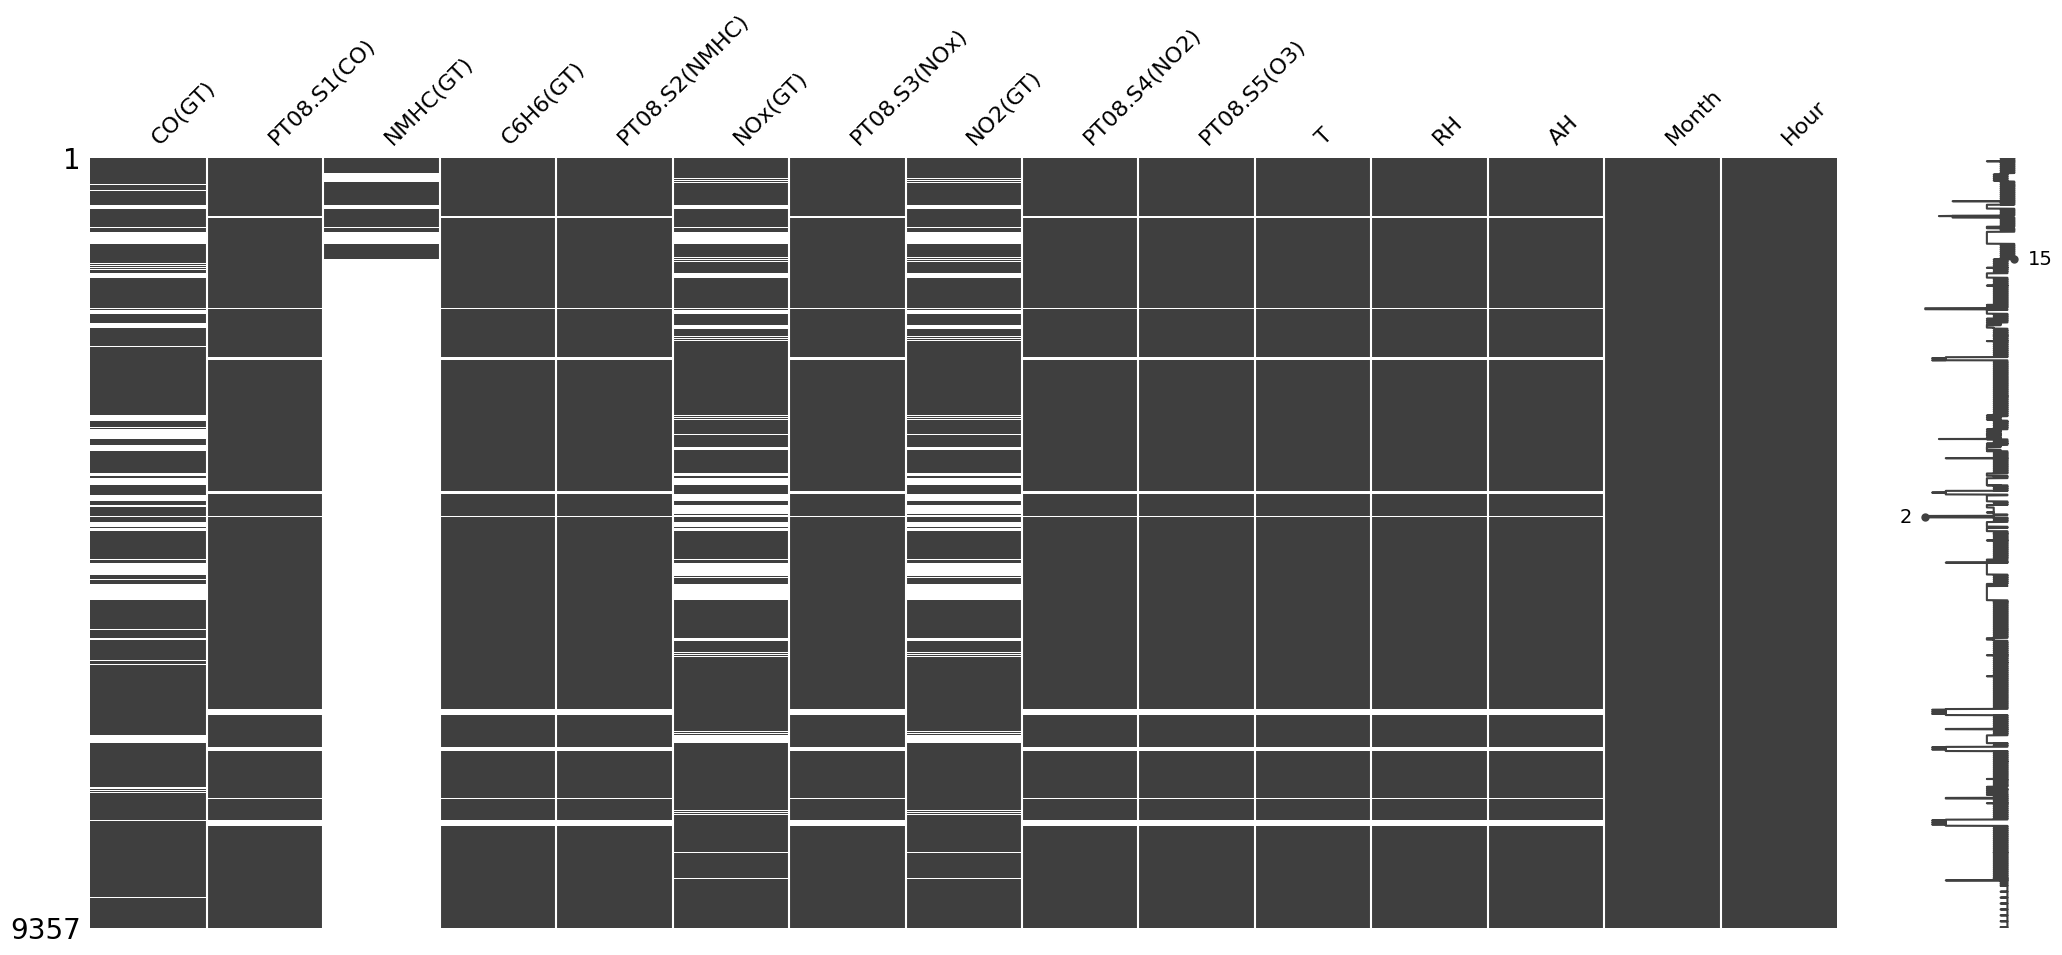

In [16]:
_ = msno.matrix(df)

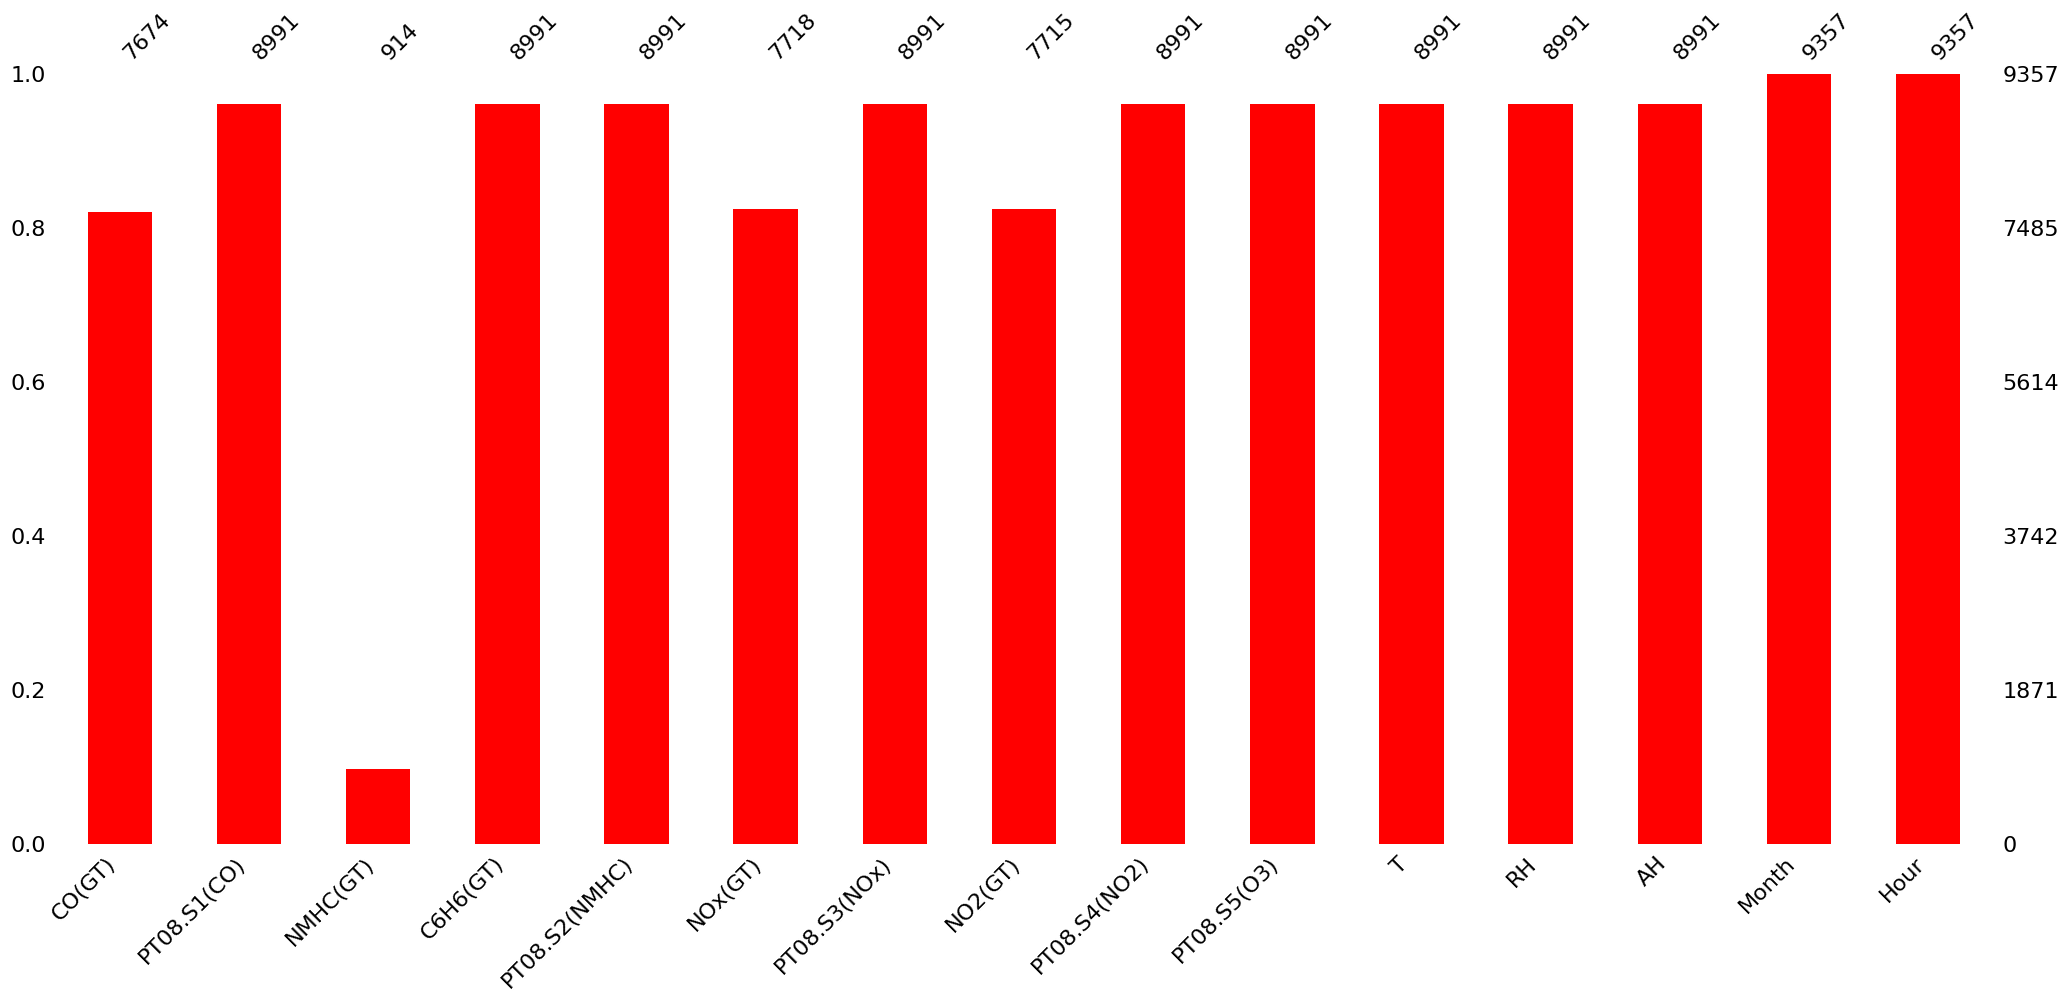

In [17]:
_ = msno.bar(df, color="red")

The feature : **`NMHC(GT)`** has a high proportion of NaN elements 

$\Longrightarrow$ This column cannot provide meaningful conclusion on the selected target.

$\Longrightarrow$ We decide to remove the column **`NMHC(GT)`**.

In [18]:
# Dropping the column NMHC(GT)
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['NMHC(GT)'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Column already removed.")
df

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,2
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,4,1
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,4,11
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,4,12
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,4,13


The other columns have a proportion of non-NaN greater than $80 \ \%$, which contains most of the information of the corresponding feature; we can replace these NaN values by a significant statistical indicator such as : median or mean value.

$\Longrightarrow$ We choose the **average** value here.

In [19]:
# Removing the NMHC(GT) column
try:
    columns_float.remove('NMHC(GT)')
except ValueError:
    pass
columns_float
for c in columns_float:
    df[c].fillna(df[c].mean(), inplace=True) # or .median()

In [20]:
# Computing the percentage of remaining missing values
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
Month            0.0
Hour             0.0
dtype: float64

We're good to go !

In [21]:
df.head(10)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,11.9,1046.0,166.000000,1056.0,113.000000,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,9.4,955.0,103.000000,1174.0,92.000000,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,9.0,939.0,131.000000,1140.0,114.000000,1555.0,1074.0,11.9,54.0,0.7502,3,2
3,2.2,1376.0,9.2,948.0,172.000000,1092.0,122.000000,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,6.5,836.0,131.000000,1205.0,116.000000,1490.0,1110.0,11.2,59.6,0.7888,3,22
5,1.2,1197.0,4.7,750.0,89.000000,1337.0,96.000000,1393.0,949.0,11.2,59.2,0.7848,3,23
6,1.2,1185.0,3.6,690.0,62.000000,1462.0,77.000000,1333.0,733.0,11.3,56.8,0.7603,3,0
7,1.0,1136.0,3.3,672.0,62.000000,1453.0,76.000000,1333.0,730.0,10.7,60.0,0.7702,3,1
8,0.9,1094.0,2.3,609.0,45.000000,1579.0,60.000000,1276.0,620.0,10.7,59.7,0.7648,3,2
9,0.6,1010.0,1.7,561.0,246.896735,1705.0,113.091251,1235.0,501.0,10.3,60.2,0.7517,3,3


In [22]:
# Saving the pre-processed dataset on disk
df.to_csv(path_or_buf="data/processed_dataset.csv",
         sep=";",
         header=True)

### $X$/$Y$ dataset split

We now have to split the main dataset into $X$ and $Y$ dataframes.

As a reminder:
- $X$ represents the features matrix
- $Y$ represents the target variable (as a vector or Pandas Series to be more precise)

In [238]:
# Splitting the dataset
X = df.copy() # X as a deep copy for security reason
Y = X.pop("T")

In [239]:
# Features
X.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,Month,Hour
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,3,18
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,3,19
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,3,2
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,3,21
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,3,22


In [240]:
# Target
Y.head()

0    13.6
1    13.3
2    11.9
3    11.0
4    11.2
Name: T, dtype: float64

### Handling outliers

<p style="color:red"> 
    <b>WARNING</b>: This step has to be performed <b>RIGHT AFTER</b> the train/test/validation split <b>AND ONLY</b> on the train set.
</p>

In order to check the presence of outliers within our dataset, we analyze the box-plot of each column.

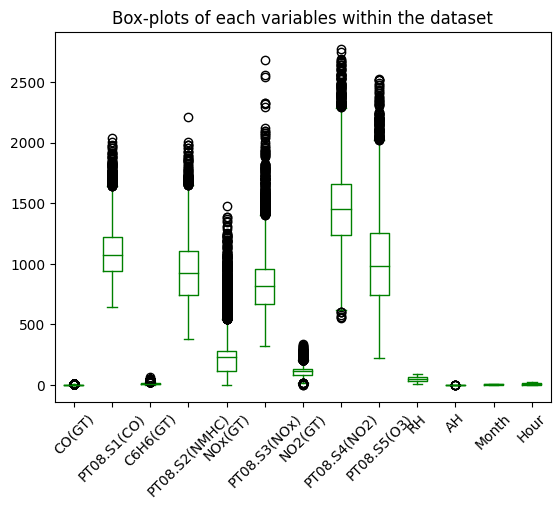

In [241]:
X.plot(kind="box",
       title="Box-plots of each variables within the dataset",
       color="green", xlabel=None)
_ = plt.xticks(rotation=45)

We can observe a lot of outliers, in particular for `PT08.S1(CO)`, `NOx(GT)`, and `PT08.S3(NOx)`and `PT08.S4(NO2)`.

At first sight, we wanted to perform some data pre-processing on the outliers. Our first track was to implement the **Winsorize method** which rescales the observations and tries to replace the outliers by "normal values".

However, since we don't want to facilitate **over-fitting** potential behaviors and as we also want to introduce noise in the coming steps within the feedforwarding step, we do not pursue on this track.

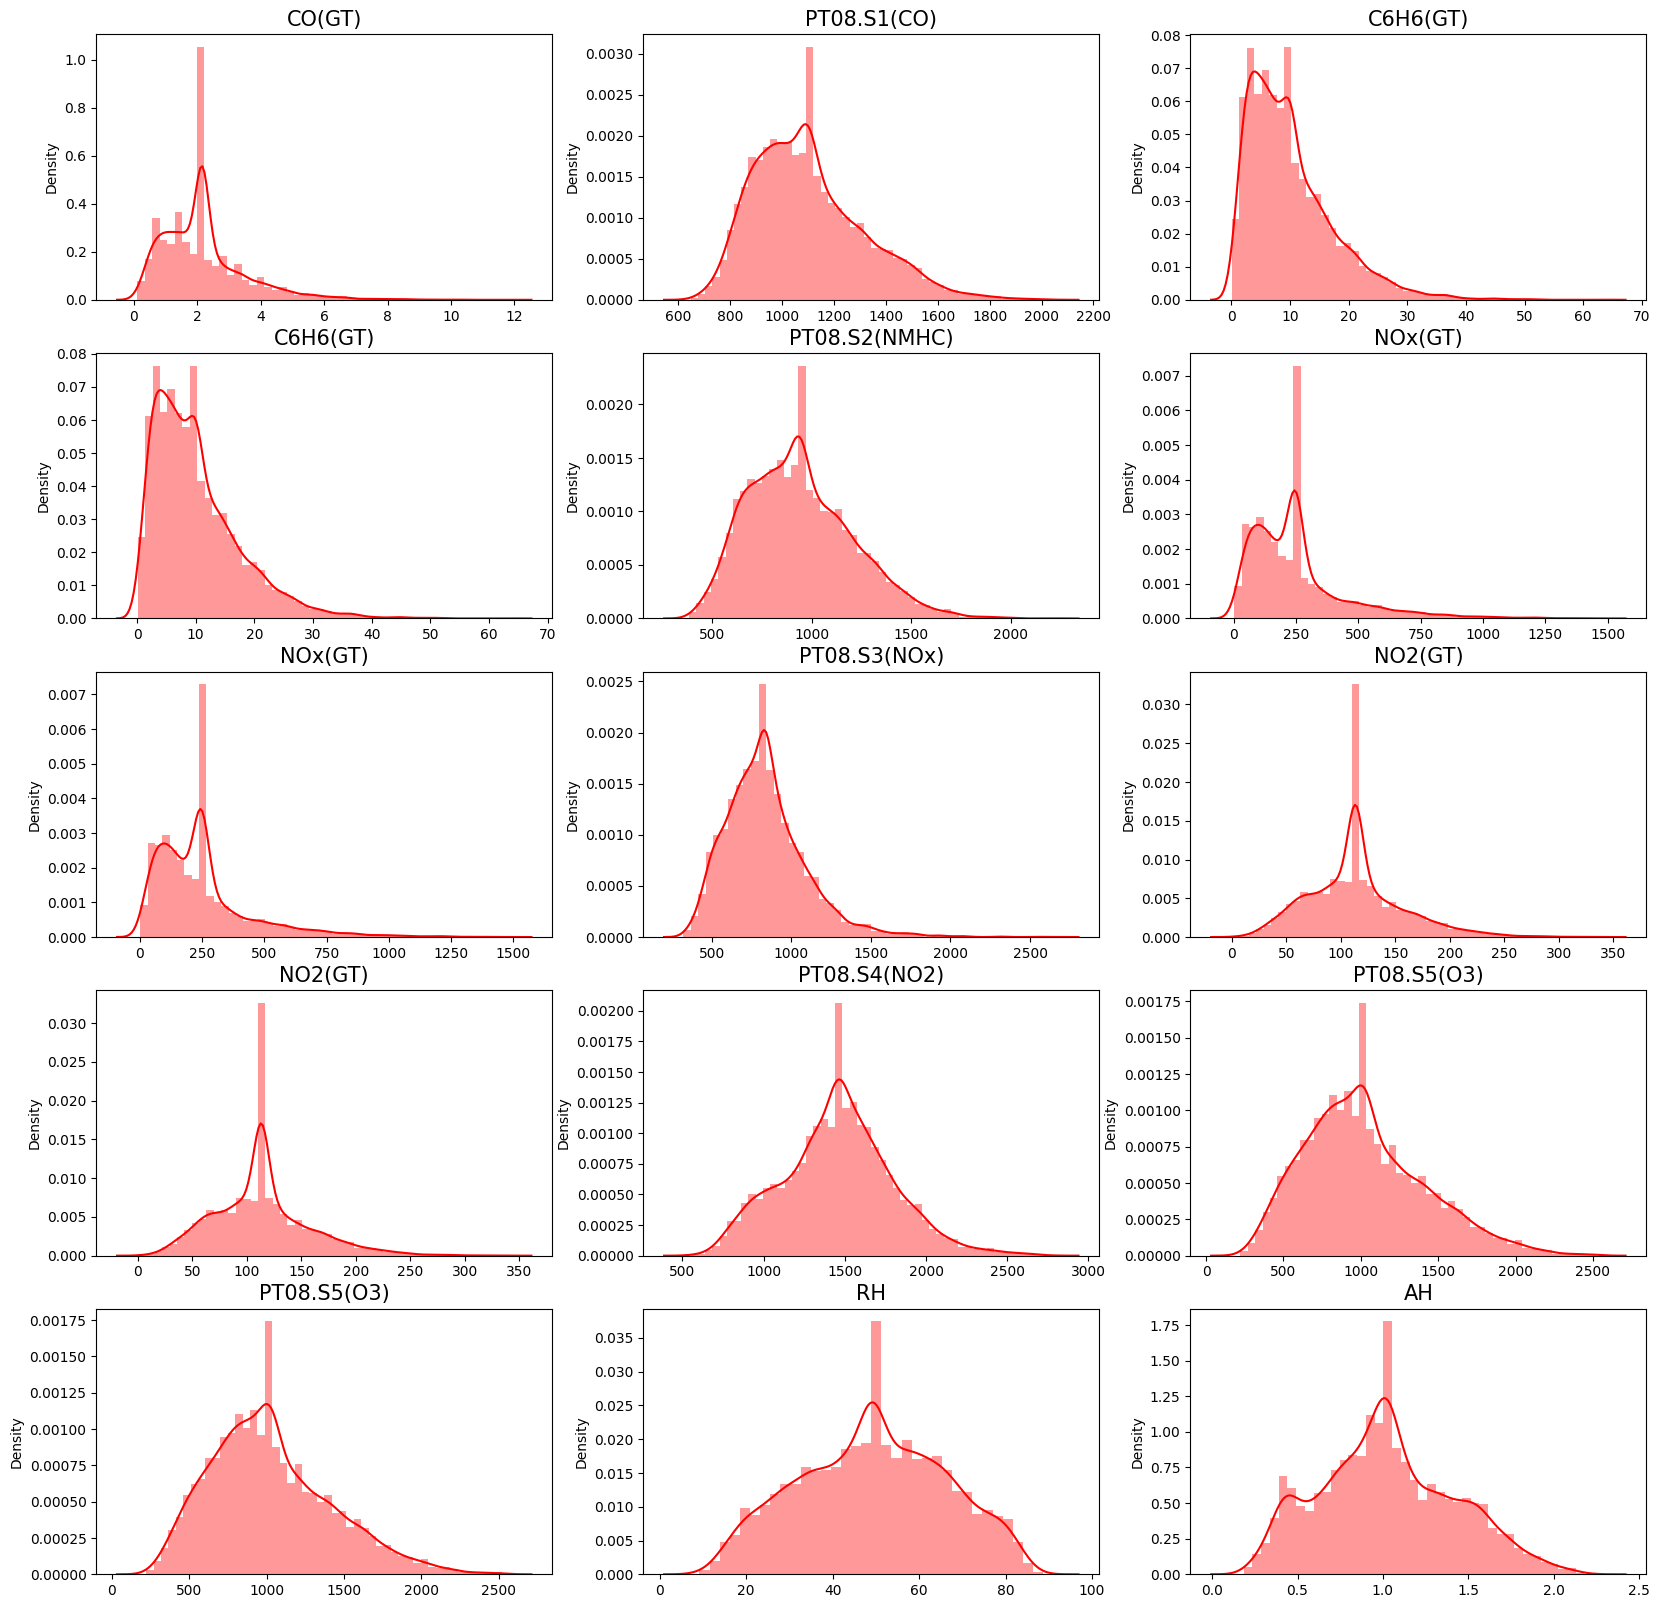

In [242]:
# Plotting distribution plots for each column
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        g = sns.distplot(X[X.columns[i*2+j]], ax=ax[i][j], color="red")
        g.set(xlabel=None)
        g.set_title(X[X.columns[i*2+j]].name, fontsize = 15)

### Handling high-correlated data

Linear regression cannot perform a good fitting process with highly-correlated features.
Given a specific threshold, we will remove the most correlated variables in order to obtain consistent results.

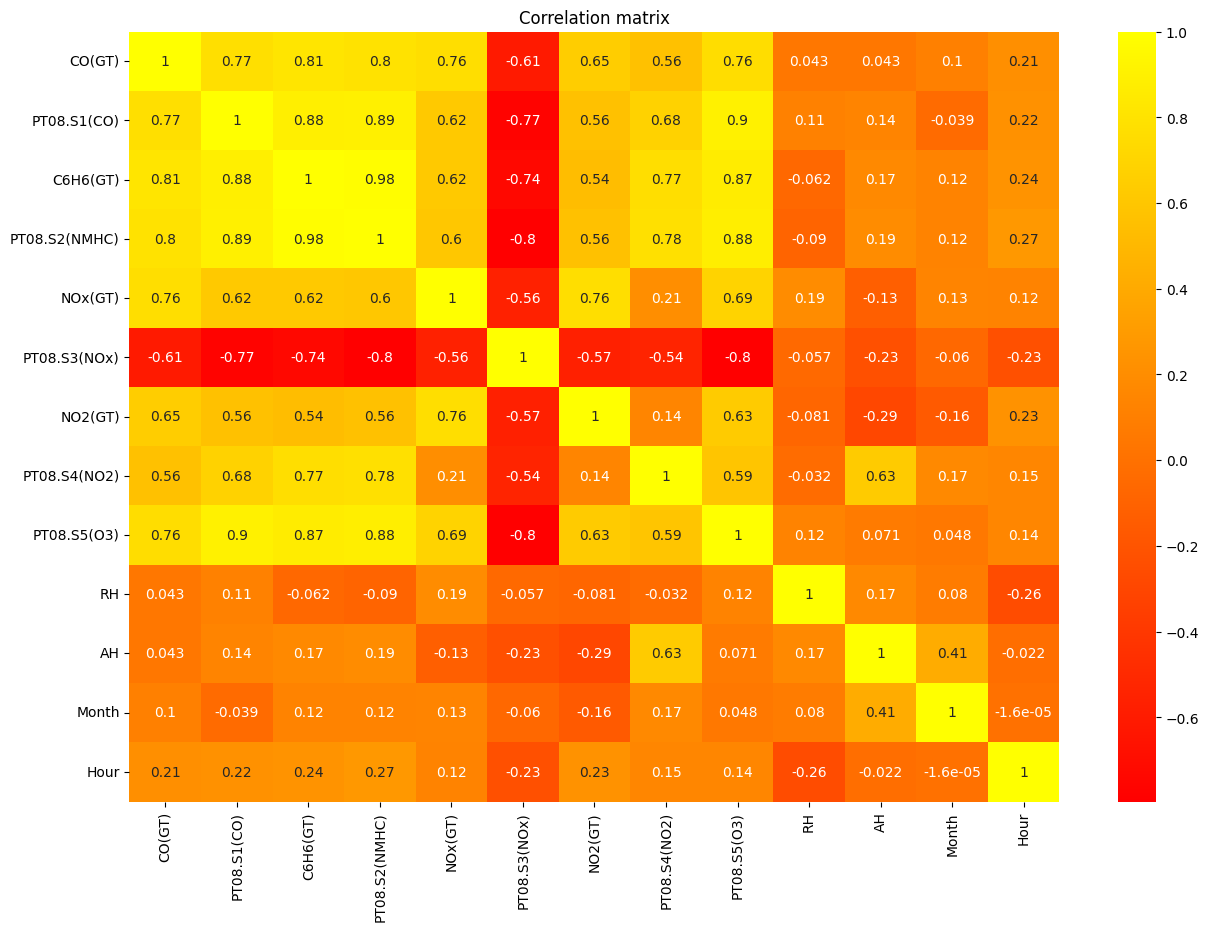

In [243]:
# Computing and plotting the correlation matrix of the final dataset
plt.figure(figsize=(15, 10))
correlation_matrix = X.corr() #.abs()
sns.heatmap(correlation_matrix, annot=True, cmap="autumn")
plt.title("Correlation matrix")
plt.show()

We remark that the upper left-hand corner contains highly-correlated variables.

In [37]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
HIGH_CORRELATION_THRESHOLD = 0.88
to_drop = [column for column in upper.columns if any(upper[column] > HIGH_CORRELATION_THRESHOLD)]
print(f"We drop the following variables: {to_drop}")

We drop the following variables: ['C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S5(O3)']


With a threshold of $0.88$, we have to remove the most high-correlated variables which are : `C6H6(GT)`, `PT08.S2(NMHC)` and `PT08.S5(O3)`.

In [40]:
# Drop selected features
try:
    if len(to_drop) != 0:
        print(f"We drop the following variables: {to_drop}")
        X.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
    else:
        print("High-correlated features have already been removed by the user.")
except:
    print("High-correlated features have already been removed by the user.")

We drop the following variables: ['C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S5(O3)']
High-correlated features have already been removed by the user.


In [39]:
# (Obsolete) Alternative method to find pairs of heavy-correlated variables
#c = df.corr().abs()
#s = c.unstack()
#so = s.sort_values(kind="quicksort")
#so.drop(so)
#HIGH_CORRELATION_THRESHOLD = 0.85
#so[(so != 1.0) & (so > HIGH_CORRELATION_THRESHOLD)].drop_duplicates().keys()

### Train/test dataset split

In [244]:
# Size setting
SIZE_SAMPLE_TEST = 0.2
SIZE_SAMPLE_VALIDATION = 0.25

# Creation of training and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = SIZE_SAMPLE_TEST)
# Shuffling
X_train.sample(frac=1)
X_test.sample(frac=1)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,Month,Hour
7093,2.15275,820.0,1.1,506.0,246.896735,1221.0,113.091251,871.0,466.0,47.8,0.5157,12,7
7646,2.15275,879.0,2.1,594.0,134.000000,1119.0,98.000000,839.0,792.0,54.1,0.4017,1,8
5958,0.80000,780.0,1.8,568.0,100.000000,1190.0,57.000000,997.0,453.0,55.5,0.7711,11,0
8372,3.00000,1209.0,12.9,1082.0,407.000000,573.0,238.000000,1355.0,1105.0,71.0,0.6903,2,14
3730,0.50000,817.0,1.7,558.0,7.000000,1232.0,11.000000,1485.0,452.0,63.1,2.0184,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,5.60000,1583.0,26.1,1457.0,745.000000,376.0,189.000000,1808.0,1976.0,51.0,0.7704,3,9
1974,0.30000,922.0,4.7,750.0,46.000000,1085.0,45.000000,1585.0,685.0,75.7,1.6074,6,0
597,2.15275,1296.0,10.0,977.0,246.896735,863.0,113.091251,1642.0,746.0,30.8,1.0253,4,15
5240,2.15275,862.0,3.0,649.0,246.896735,1046.0,113.091251,1289.0,675.0,84.6,1.3794,10,2


In [42]:
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=SIZE_SAMPLE_VALIDATION)

# Shuffling
#X_train.sample(frac=1)
#X_val.sample(frac=1)

#### Outliers detection & correction

In [43]:
def apply_outliers_detect_col(col):
    """
    Function returning an outliers-corrected column from the initial column : col
    :param col: Initial column
    """
    return winsorize(col, limits=[0.05, 0.05])

def apply_outliers_detect(df):
    """
    Function returnin an outliers-corrected dataframe from the initial dataframe : df
    :param df: Initial dataframe
    """
    return df.apply(apply_outliers_detect_col, axis = 0)

# Applying the filtering of outliers on the train dataset ONLY
#X_train = apply_outliers_detect(X_train)
#X_train

### Features normalization

We can use one of the several scalers available in *scikit-learn*:

- `MinMaxScaler`: subtracts the min value in the feature and dividing by the range of the feature. The MinMaxScaler does not change the shape of the distribution but shrinks the frequency distribution between 0 to 1.  
- `StandardScaler`: rescales the data by subtracting all the entries from the mean value and dividing it by the standard deviation. After a StandardScaler step has been carried out, the mean of the distribution is equal to zero while 67.7% of the distribution falls between -1 and 1
- `RobustScaler` : subtracts the median value from each entry and divides by the interquartile range (IQR) of the feature. Since RobustScaler divides by the interquartile range, the returned frequency distribution penalizes outliers. This makes RobustScaler robust for data with outliers. 


$\Longrightarrow$ Since we have a lot of outliers on many features (see previous sections), we are encouraged to use the `RobustScaler` transform.

In [247]:
# Normalization process using the RobustScaler processor
scaler = MinMaxScaler() # RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [248]:
# New results scaled and centered
X_train

array([[0.09322034, 0.32507765, 0.15696706, ..., 0.41090274, 1.        ,
        0.30434783],
       [0.05932203, 0.19813352, 0.0754717 , ..., 0.34970434, 0.27272727,
        0.26086957],
       [0.03389831, 0.11629576, 0.03144654, ..., 0.57088403, 0.81818182,
        0.08695652],
       ...,
       [0.20338983, 0.34816942, 0.2091195 , ..., 0.41694766, 0.36363636,
        0.04347826],
       [0.10169492, 0.16941852, 0.07861635, ..., 0.16791282, 0.27272727,
        0.60869565],
       [0.20338983, 0.38406317, 0.22012579, ..., 0.64374725, 0.45454545,
        0.56521739]])

In [249]:
X_test

array([[0.29661017, 0.45585068, 0.21540881, ..., 0.41948883, 0.90909091,
        0.56521739],
       [0.17396183, 0.38262742, 0.23899371, ..., 0.69305576, 0.63636364,
        0.04347826],
       [0.1440678 , 0.41134243, 0.08805031, ..., 0.55519719, 0.18181818,
        0.82608696],
       ...,
       [0.07627119, 0.32447954, 0.06132075, ..., 0.5233348 , 0.18181818,
        0.08695652],
       [0.05932203, 0.25699928, 0.08647799, ..., 0.84596589, 0.63636364,
        0.26086957],
       [0.1440678 , 0.32232592, 0.17295597, ..., 0.50036652, 0.54545455,
        0.30434783]])

## NN model

We want to study the effect of the following hyper-parameters:
- $\#$ of layers
- $\#$ of neurons
- learning rate
- regularization
- activation functions
- impact of normalizing your dataset
- impact of noising your dataset (after normalization)

### Preliminary steps

In [149]:
"""
Available callbacks:
- tfa.callbacks.TQDMProgressBar()
- livelossplot.PlotLossesKeras()
- keras_tqdm() <-- to be avoided
"""

# Initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

# Simple assertion for technical reason
tf.keras.models.Sequential == tf.keras.Sequential

True

### Model's creation and parametrization

In [256]:
# Creation of the neural network
model = Sequential()

# Input layer
model.add(Dense(units=12, input_dim=13, activation="relu"))
# WARNING: the parameter input_dim has to be exactly equal to the number of column of X_train

# Hidden layers
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(4, activation='relu'))

# Output layer
model.add(Dense(1, activation='linear'))

#### Model's architecture graphical representation

We can visualize the model graphically as shown below:

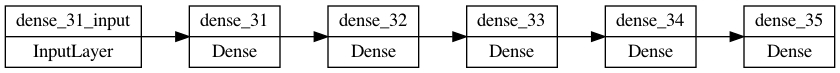

In [257]:
plot_model(model,
           to_file="img/graph_nn_1_alt.png",
           rankdir="LR")

A better graphical approach is:

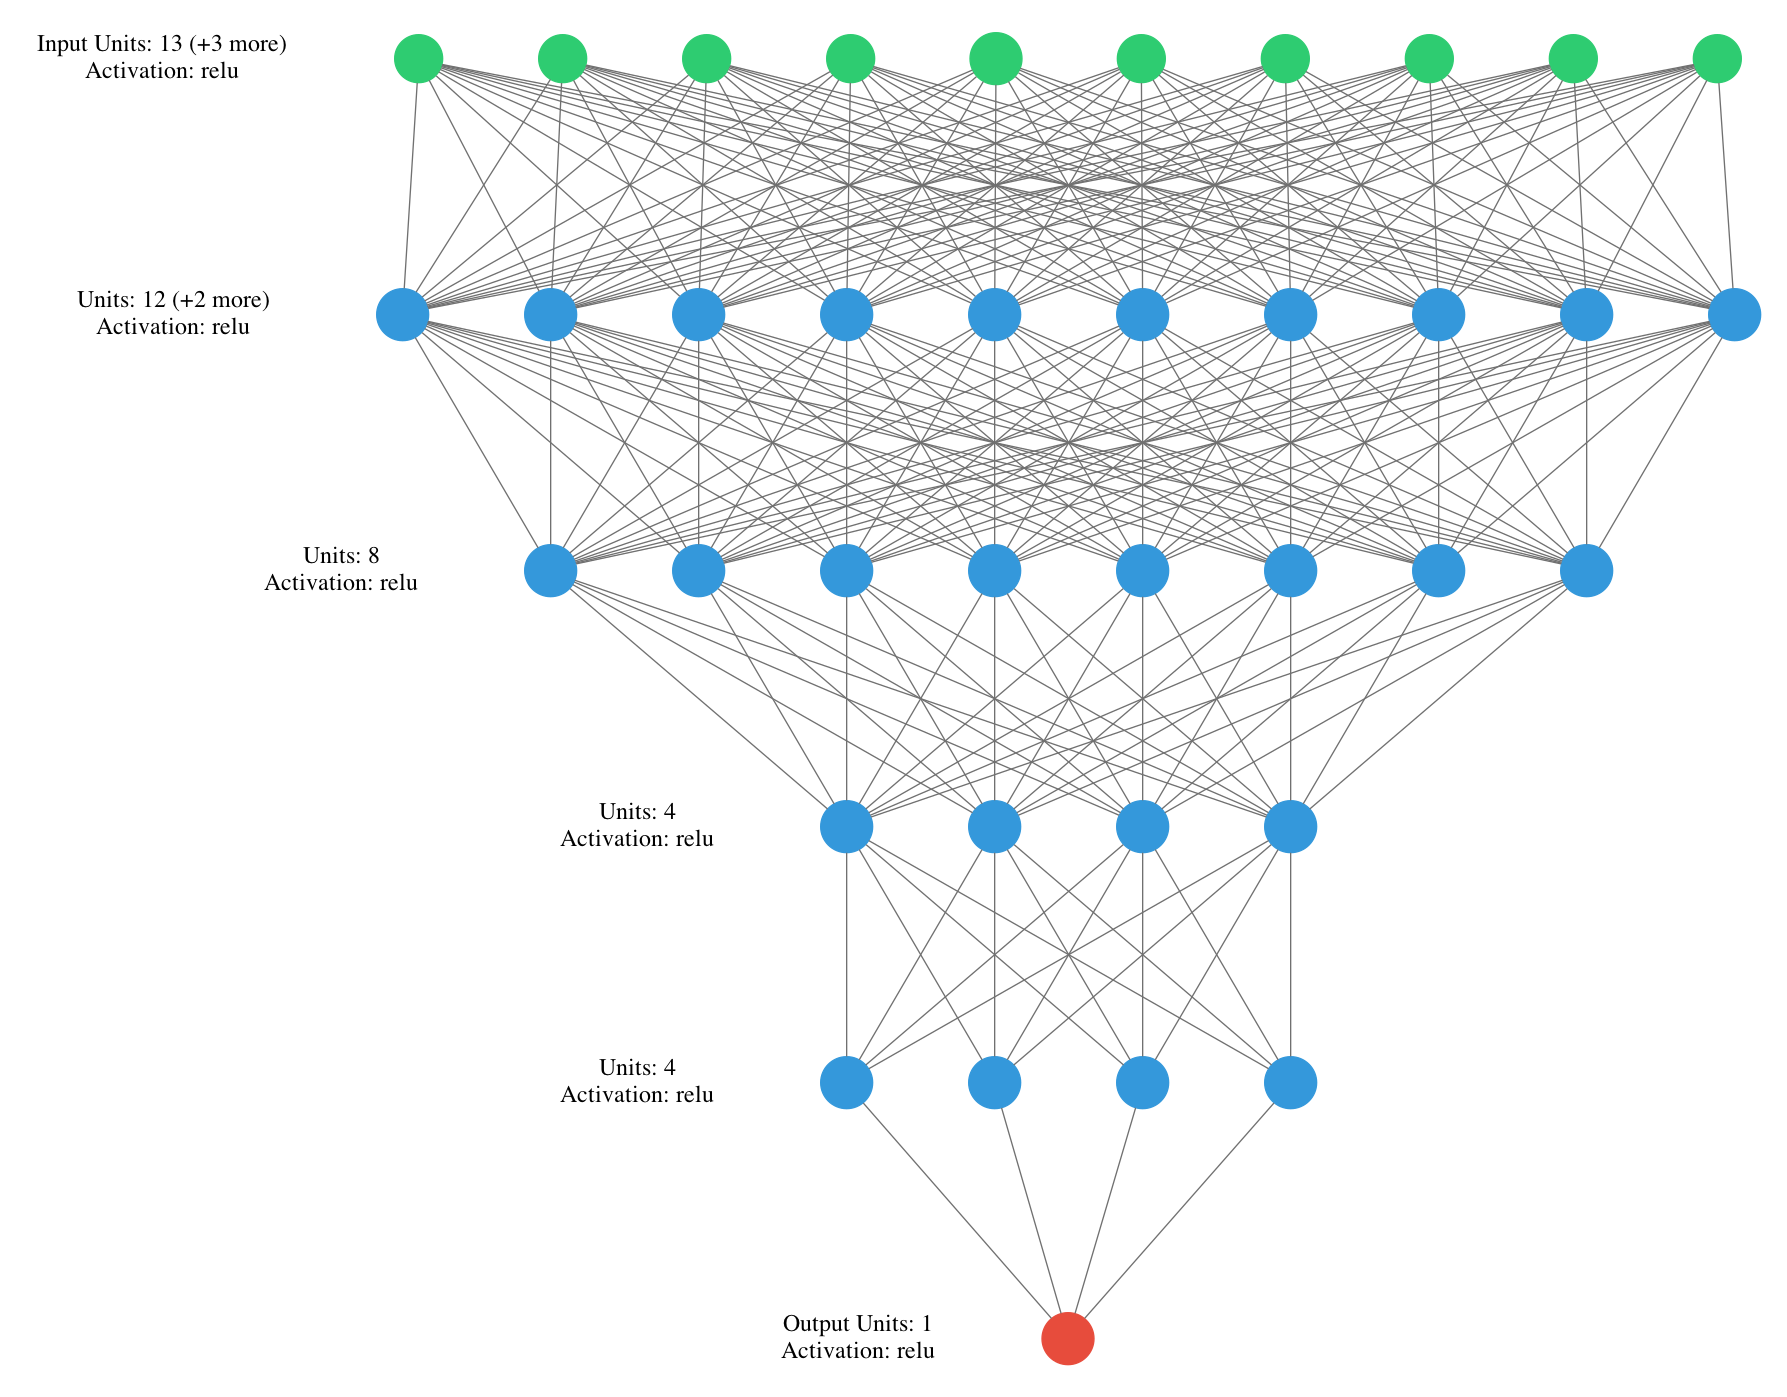

In [258]:
visualizer(model, 
           filename="img/graph_nn_1", 
           format='png', 
           view=False
          )
Image("img/graph_nn_1.png")

#### Model's parameters

We now have to compile and fit the model with the training dataset:

In [267]:
# Definition of the different arguments
eta = 1e-2 # generally between 1e-2 and 1e-4
NB_EPOCHS = 200

# Setting up the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=eta)

# Compiling the model
model.compile(loss='mse', 
              optimizer=optimizer, 
              metrics=['mse', 'mae']
             )

**References**:

- https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10

In [268]:
# Fit step of the model
history = model.fit(X_train, Y_train, 
                    epochs=NB_EPOCHS,
                    validation_split=0.3,
                    verbose=0,
                    callbacks=[tqdm_callback],
                    batch_size=10
                   )

Training:   0%|    0/200 ETA: ?s,  ?epochs/s

Epoch 1/200


0/524                             ETA: ?s - 

Epoch 2/200


0/524                             ETA: ?s - 

Epoch 3/200


0/524                             ETA: ?s - 

Epoch 4/200


0/524                             ETA: ?s - 

Epoch 5/200


0/524                             ETA: ?s - 

Epoch 6/200


0/524                             ETA: ?s - 

Epoch 7/200


0/524                             ETA: ?s - 

Epoch 8/200


0/524                             ETA: ?s - 

Epoch 9/200


0/524                             ETA: ?s - 

Epoch 10/200


0/524                             ETA: ?s - 

Epoch 11/200


0/524                             ETA: ?s - 

Epoch 12/200


0/524                             ETA: ?s - 

Epoch 13/200


0/524                             ETA: ?s - 

Epoch 14/200


0/524                             ETA: ?s - 

Epoch 15/200


0/524                             ETA: ?s - 

Epoch 16/200


0/524                             ETA: ?s - 

Epoch 17/200


0/524                             ETA: ?s - 

Epoch 18/200


0/524                             ETA: ?s - 

Epoch 19/200


0/524                             ETA: ?s - 

Epoch 20/200


0/524                             ETA: ?s - 

Epoch 21/200


0/524                             ETA: ?s - 

Epoch 22/200


0/524                             ETA: ?s - 

Epoch 23/200


0/524                             ETA: ?s - 

Epoch 24/200


0/524                             ETA: ?s - 

Epoch 25/200


0/524                             ETA: ?s - 

Epoch 26/200


0/524                             ETA: ?s - 

Epoch 27/200


0/524                             ETA: ?s - 

Epoch 28/200


0/524                             ETA: ?s - 

Epoch 29/200


0/524                             ETA: ?s - 

Epoch 30/200


0/524                             ETA: ?s - 

Epoch 31/200


0/524                             ETA: ?s - 

Epoch 32/200


0/524                             ETA: ?s - 

Epoch 33/200


0/524                             ETA: ?s - 

Epoch 34/200


0/524                             ETA: ?s - 

Epoch 35/200


0/524                             ETA: ?s - 

Epoch 36/200


0/524                             ETA: ?s - 

Epoch 37/200


0/524                             ETA: ?s - 

Epoch 38/200


0/524                             ETA: ?s - 

Epoch 39/200


0/524                             ETA: ?s - 

Epoch 40/200


0/524                             ETA: ?s - 

Epoch 41/200


0/524                             ETA: ?s - 

Epoch 42/200


0/524                             ETA: ?s - 

Epoch 43/200


0/524                             ETA: ?s - 

Epoch 44/200


0/524                             ETA: ?s - 

Epoch 45/200


0/524                             ETA: ?s - 

Epoch 46/200


0/524                             ETA: ?s - 

Epoch 47/200


0/524                             ETA: ?s - 

Epoch 48/200


0/524                             ETA: ?s - 

Epoch 49/200


0/524                             ETA: ?s - 

Epoch 50/200


0/524                             ETA: ?s - 

Epoch 51/200


0/524                             ETA: ?s - 

Epoch 52/200


0/524                             ETA: ?s - 

Epoch 53/200


0/524                             ETA: ?s - 

Epoch 54/200


0/524                             ETA: ?s - 

Epoch 55/200


0/524                             ETA: ?s - 

Epoch 56/200


0/524                             ETA: ?s - 

Epoch 57/200


0/524                             ETA: ?s - 

Epoch 58/200


0/524                             ETA: ?s - 

Epoch 59/200


0/524                             ETA: ?s - 

Epoch 60/200


0/524                             ETA: ?s - 

Epoch 61/200


0/524                             ETA: ?s - 

Epoch 62/200


0/524                             ETA: ?s - 

Epoch 63/200


0/524                             ETA: ?s - 

Epoch 64/200


0/524                             ETA: ?s - 

Epoch 65/200


0/524                             ETA: ?s - 

Epoch 66/200


0/524                             ETA: ?s - 

Epoch 67/200


0/524                             ETA: ?s - 

Epoch 68/200


0/524                             ETA: ?s - 

Epoch 69/200


0/524                             ETA: ?s - 

Epoch 70/200


0/524                             ETA: ?s - 

Epoch 71/200


0/524                             ETA: ?s - 

Epoch 72/200


0/524                             ETA: ?s - 

Epoch 73/200


0/524                             ETA: ?s - 

Epoch 74/200


0/524                             ETA: ?s - 

Epoch 75/200


0/524                             ETA: ?s - 

Epoch 76/200


0/524                             ETA: ?s - 

Epoch 77/200


0/524                             ETA: ?s - 

Epoch 78/200


0/524                             ETA: ?s - 

Epoch 79/200


0/524                             ETA: ?s - 

Epoch 80/200


0/524                             ETA: ?s - 

Epoch 81/200


0/524                             ETA: ?s - 

Epoch 82/200


0/524                             ETA: ?s - 

Epoch 83/200


0/524                             ETA: ?s - 

Epoch 84/200


0/524                             ETA: ?s - 

Epoch 85/200


0/524                             ETA: ?s - 

Epoch 86/200


0/524                             ETA: ?s - 

Epoch 87/200


0/524                             ETA: ?s - 

Epoch 88/200


0/524                             ETA: ?s - 

Epoch 89/200


0/524                             ETA: ?s - 

Epoch 90/200


0/524                             ETA: ?s - 

Epoch 91/200


0/524                             ETA: ?s - 

Epoch 92/200


0/524                             ETA: ?s - 

Epoch 93/200


0/524                             ETA: ?s - 

Epoch 94/200


0/524                             ETA: ?s - 

Epoch 95/200


0/524                             ETA: ?s - 

Epoch 96/200


0/524                             ETA: ?s - 

Epoch 97/200


0/524                             ETA: ?s - 

Epoch 98/200


0/524                             ETA: ?s - 

Epoch 99/200


0/524                             ETA: ?s - 

Epoch 100/200


0/524                             ETA: ?s - 

Epoch 101/200


0/524                             ETA: ?s - 

Epoch 102/200


0/524                             ETA: ?s - 

Epoch 103/200


0/524                             ETA: ?s - 

Epoch 104/200


0/524                             ETA: ?s - 

Epoch 105/200


0/524                             ETA: ?s - 

Epoch 106/200


0/524                             ETA: ?s - 

Epoch 107/200


0/524                             ETA: ?s - 

Epoch 108/200


0/524                             ETA: ?s - 

Epoch 109/200


0/524                             ETA: ?s - 

Epoch 110/200


0/524                             ETA: ?s - 

Epoch 111/200


0/524                             ETA: ?s - 

Epoch 112/200


0/524                             ETA: ?s - 

Epoch 113/200


0/524                             ETA: ?s - 

Epoch 114/200


0/524                             ETA: ?s - 

Epoch 115/200


0/524                             ETA: ?s - 

Epoch 116/200


0/524                             ETA: ?s - 

Epoch 117/200


0/524                             ETA: ?s - 

Epoch 118/200


0/524                             ETA: ?s - 

Epoch 119/200


0/524                             ETA: ?s - 

Epoch 120/200


0/524                             ETA: ?s - 

Epoch 121/200


0/524                             ETA: ?s - 

Epoch 122/200


0/524                             ETA: ?s - 

Epoch 123/200


0/524                             ETA: ?s - 

Epoch 124/200


0/524                             ETA: ?s - 

Epoch 125/200


0/524                             ETA: ?s - 

Epoch 126/200


0/524                             ETA: ?s - 

Epoch 127/200


0/524                             ETA: ?s - 

Epoch 128/200


0/524                             ETA: ?s - 

Epoch 129/200


0/524                             ETA: ?s - 

Epoch 130/200


0/524                             ETA: ?s - 

Epoch 131/200


0/524                             ETA: ?s - 

Epoch 132/200


0/524                             ETA: ?s - 

Epoch 133/200


0/524                             ETA: ?s - 

Epoch 134/200


0/524                             ETA: ?s - 

Epoch 135/200


0/524                             ETA: ?s - 

Epoch 136/200


0/524                             ETA: ?s - 

Epoch 137/200


0/524                             ETA: ?s - 

Epoch 138/200


0/524                             ETA: ?s - 

Epoch 139/200


0/524                             ETA: ?s - 

Epoch 140/200


0/524                             ETA: ?s - 

Epoch 141/200


0/524                             ETA: ?s - 

Epoch 142/200


0/524                             ETA: ?s - 

Epoch 143/200


0/524                             ETA: ?s - 

Epoch 144/200


0/524                             ETA: ?s - 

Epoch 145/200


0/524                             ETA: ?s - 

Epoch 146/200


0/524                             ETA: ?s - 

Epoch 147/200


0/524                             ETA: ?s - 

Epoch 148/200


0/524                             ETA: ?s - 

Epoch 149/200


0/524                             ETA: ?s - 

Epoch 150/200


0/524                             ETA: ?s - 

Epoch 151/200


0/524                             ETA: ?s - 

Epoch 152/200


0/524                             ETA: ?s - 

Epoch 153/200


0/524                             ETA: ?s - 

Epoch 154/200


0/524                             ETA: ?s - 

Epoch 155/200


0/524                             ETA: ?s - 

Epoch 156/200


0/524                             ETA: ?s - 

Epoch 157/200


0/524                             ETA: ?s - 

Epoch 158/200


0/524                             ETA: ?s - 

Epoch 159/200


0/524                             ETA: ?s - 

Epoch 160/200


0/524                             ETA: ?s - 

Epoch 161/200


0/524                             ETA: ?s - 

Epoch 162/200


0/524                             ETA: ?s - 

Epoch 163/200


0/524                             ETA: ?s - 

Epoch 164/200


0/524                             ETA: ?s - 

Epoch 165/200


0/524                             ETA: ?s - 

Epoch 166/200


0/524                             ETA: ?s - 

Epoch 167/200


0/524                             ETA: ?s - 

Epoch 168/200


0/524                             ETA: ?s - 

Epoch 169/200


0/524                             ETA: ?s - 

Epoch 170/200


0/524                             ETA: ?s - 

Epoch 171/200


0/524                             ETA: ?s - 

Epoch 172/200


0/524                             ETA: ?s - 

Epoch 173/200


0/524                             ETA: ?s - 

Epoch 174/200


0/524                             ETA: ?s - 

Epoch 175/200


0/524                             ETA: ?s - 

Epoch 176/200


0/524                             ETA: ?s - 

Epoch 177/200


0/524                             ETA: ?s - 

Epoch 178/200


0/524                             ETA: ?s - 

Epoch 179/200


0/524                             ETA: ?s - 

Epoch 180/200


0/524                             ETA: ?s - 

Epoch 181/200


0/524                             ETA: ?s - 

Epoch 182/200


0/524                             ETA: ?s - 

Epoch 183/200


0/524                             ETA: ?s - 

Epoch 184/200


0/524                             ETA: ?s - 

Epoch 185/200


0/524                             ETA: ?s - 

Epoch 186/200


0/524                             ETA: ?s - 

Epoch 187/200


0/524                             ETA: ?s - 

Epoch 188/200


0/524                             ETA: ?s - 

Epoch 189/200


0/524                             ETA: ?s - 

Epoch 190/200


0/524                             ETA: ?s - 

Epoch 191/200


0/524                             ETA: ?s - 

Epoch 192/200


0/524                             ETA: ?s - 

Epoch 193/200


0/524                             ETA: ?s - 

Epoch 194/200


0/524                             ETA: ?s - 

Epoch 195/200


0/524                             ETA: ?s - 

Epoch 196/200


0/524                             ETA: ?s - 

Epoch 197/200


0/524                             ETA: ?s - 

Epoch 198/200


0/524                             ETA: ?s - 

Epoch 199/200


0/524                             ETA: ?s - 

Epoch 200/200


0/524                             ETA: ?s - 

### Evaluation

In [215]:
# To be called right AFTER fitting operation
METRICS = model.metrics_names

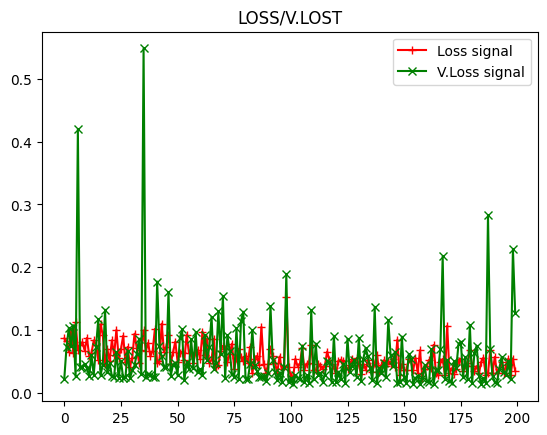

In [269]:
# Plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
history_df.head(10)
plt.plot(history_df['loss'], "r+-", label='Loss signal')
plt.plot(history_df['val_loss'], "gx-", label='V.Loss signal')
plt.title("LOSS/V.LOST")
plt.legend()

In [270]:
# Evaluation on the test set with the same parameters (batch_size equal)
scores = model.evaluate(X_test, Y_test,
                       batch_size=10,
                       verbose=0,
                       callbacks=[tqdm_callback])

# Printing in a more human-friendly interface the different scores
s = {k[1]:scores[0] for k in enumerate(METRICS)}
print(f"Statistics ==> {s}")

0/188                   ETA: ?s - Evaluating

Statistics ==> {'loss': 0.12629485130310059, 'mse': 0.12629485130310059, 'mae': 0.12629485130310059}


In [271]:
# Prediction on the test set
Y_pred = model.predict(X_test).flatten()

59/59 [==============================] - 0s 643us/step


In [272]:
# Computing the main statistical indicators
AE = np.abs(Y_pred - Y_test)
SE = np.square(Y_pred - Y_test) 
RSE = np.sqrt(SE)
MAE = np.mean(AE)
MSE = np.mean(SE)
RMSE = np.sqrt(MSE)
print(f"Statistics : \nMAE \t = {MAE}\nMSE \t = {MSE}\nRMSE \t = {RMSE}")

Statistics : 
MAE 	 = 0.31889366699102784
MSE 	 = 0.1262948154151374
RMSE 	 = 0.3553798185253876


In [295]:
# Within k-sigma ranges where k \in {1, 2, 3}
within_sigma = {k:np.sum(np.abs(Y_pred - Y_test.to_numpy()) < k*RMSE) for k in [1, 2, 3]}
print(within_sigma)

{1: 1176, 2: 1848, 3: 1871}


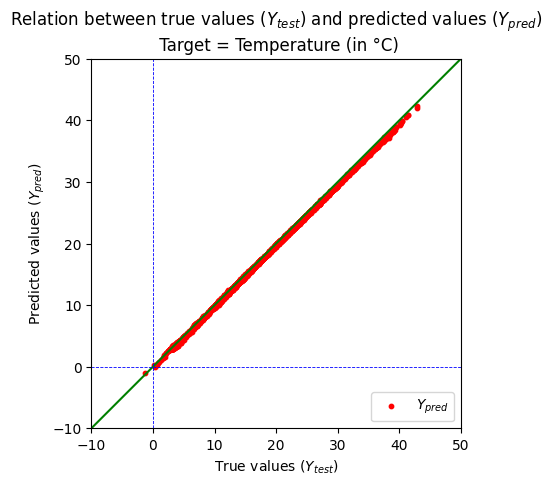

In [296]:
# Plotting the relation between the true values and the predicted ones
a = plt.axes(aspect="equal")
plt.xlabel("True values ($Y_{test}$)")
plt.ylabel("Predicted values ($Y_{pred}$)")
plt.title("Relation between true values ($Y_{test}$) and predicted values ($Y_{pred}$)\n Target = Temperature (in °C)")
_, _ = plt.xlim([-10, 50]), plt.ylim([-10, 50])
plt.plot([-10, 50], [-10, 50], color="green")
plt.scatter(Y_test, Y_pred, label="$Y_{pred}$", color="red", s = 10)
plt.axhline(y=0, color='b', lw=0.6, ls="--")
plt.axvline(x=0, color='b', lw=0.6, ls="--")
_ = plt.legend()